In [1]:
# DEFINING FETCH TABLE FUNCTION

import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

# Configuration
DB_CONFIG = {
    "username": "agowen",  # Replace with your PostgreSQL username
    "password": "Capstone",  # Replace with your PostgreSQL password
    "host": "localhost",  # Replace with your PostgreSQL host
    "port": 5432,  # Replace with your PostgreSQL port (default: 5432)
    "database": "capstone_db_testing",  # Replace with your PostgreSQL database name
}

# Connection string for PostgreSQL
CONN_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@" \
              f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Database setup
engine = create_engine(CONN_STRING)

def fetch_table_as_df(table_name,weather_event_list):
    """
    Retrieves a table from the PostgreSQL database and returns it as a Pandas DataFrame.

    Parameters:
    - table_name (str): Name of the table to fetch.
    - weather_event_list (str): Name of event to fetch information for
    Returns:
    - Pandas DataFrame containing the table data.
    """
    try:
        with engine.connect() as connection:
            query = text(f"""
            select year, 
		month, 
		global_land_temp, 
        global_ocean_temp, 
        co2_levels, 
        state_code,  
        region_name,
		count(distinct(event_type)) as weather_event_count from (
select  SUBSTRING(cast(date as varchar), 1, 4) AS year, 
        SUBSTRING(cast(date as varchar), 5, 2) AS month, 
        global_land_temp, 
        global_ocean_temp, 
        co2_levels, 
        state_code,  
        region_name,
        case when event_type in ({weather_event_list}) then event_type
		else null end as event_type
	    from {table_name}
        group by 1,2,3,4,5,6,7,8
)group by 1,2,3,4,5,6,7
;
        """)
            df = pd.read_sql(query, connection)
            return df
    except Exception as e:
        print(f"Error: {e}")
        return None


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(trained_model, X_test, y_test, class_names=None):
    # Make predictions
    y_pred = trained_model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [ ]:
# DEFINING MODEL FUNCTIONS 

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
import numpy as np
import math 

def preprocess_data(df,keep_columns):
    """Encodes categorical columns and scales numerical features."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    if not categorical_cols.empty:
        encoder = OrdinalEncoder()
        df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
    
    drop_columns = [col for col in df.columns if col not in keep_columns]
    X = df.drop(columns=drop_columns)

    #X = df.drop(columns=["weather_event_count","year","month"])
    y = df["weather_event_count"]
    
    return X, y, encoder

def train_and_evaluate(X, y,model_name="XGBClassifier", n_splits=5):
    """Performs K-Fold cross-validation and evaluates the model."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    maes = []
    
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Count the number of 1's and 0's for weight calc
        count_ones = (y_train == 1).sum()
        count_zeros = (y_train == 0).sum()

        weight = math.sqrt(count_zeros / count_ones)

        model = XGBClassifier(booster='gbtree',use_label_encoder=False, eval_metric='logloss',eta=.1,random_state=42, scale_pos_weight = weight, max_depth = 20)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if fold_idx == 1:
            show_confusion_matrix(model,X_test,y_test)
        
        acc = accuracy_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        accuracies.append(acc)
        maes.append(mae)
        
        #if fold_idx == 0:
        #    print("Fold 1 Results:")
        #    print(classification_report(y_test, y_pred))
        #    print(f"Accuracy: {acc:.4f}")
        #    print(f"Mean Absolute Error: {mae:.4f}\n")
    
    XGBClassifier_Accurcy_kfold = (f"{model_name} XGBClassifier k_fold Mean Accuracy: {np.mean(accuracies):.4f} \u00b1 {np.std(accuracies):.4f}")
    XGBClassifier_MAE_kfold = (f"{model_name} XGBClassifier k_fold Mean MAE: {np.mean(maes):.4f} \u00b1 {np.std(maes):.4f}")

    return {
        f"MAE": XGBClassifier_MAE_kfold,
        f"Accuracy": XGBClassifier_Accurcy_kfold,
        f"Model": model,
        f"Scaler": scaler
    }

def run_all_weather_event_models(table_name, all_weather_events,keep_columns):
    all_results = {}

    for event in all_weather_events:
        print(f"\n--- Processing Weather Event: {event} ---")
        
        weather_events = f"('{event}')"
        df = fetch_table_as_df(table_name, weather_events)
        
        if df.empty:
            print(f"No data for event: {event}. Skipping.\n")
            continue

        try:
            X, y, encoder = preprocess_data(df,keep_columns)
            model_name = event.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
            results = train_and_evaluate(X, y, n_splits=5, model_name=model_name)
            
            all_results[event] = {
                "MAE": results[f"MAE"],
                "Accuracy": results[f"Accuracy"],
                "Scaler": results[f"Scaler"],
                "Model": results[f"Model"],
                "Encoder": encoder
            }
            
            print(f"MAE: {all_results[event]['MAE']}")
            print(f"Accuracy: {all_results[event]['Accuracy']}")
        except Exception as e:
            print(f"Error processing event '{event}': {e}")
    
    return all_results, X, y

In [4]:
# PREDICTING

def fetch_predicting_table_as_df(table_name):
    """
    Retrieves a table from the PostgreSQL database and returns it as a Pandas DataFrame.

    Parameters:
    - table_name (str): Name of the table to fetch.

    Returns:
    - Pandas DataFrame containing the table data.
    """
    try:
        with engine.connect() as connection:
            query = text(f"SELECT SUBSTRING(cast(date as varchar), 1, 4) AS year, SUBSTRING(cast(date as varchar), 5, 2) AS month, global_land_temp, global_ocean_temp, co2_levels, state_code, region_name FROM {table_name};")
            df = pd.read_sql(query, connection)
            return df
    except Exception as e:
        print(f"Error: {e}")
        return None

def preprocess_predict_data(df,encoder,keep_columns):
    """Encodes categorical columns and scales numerical features."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    if not categorical_cols.empty:
        df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

    drop_columns = [col for col in df.columns if col not in keep_columns]
    X = df.drop(columns=drop_columns)

    return X


def predict_all_weather_event_models(table_name,training_results,keep_columns):
    all_predicted_results = {}
    event_list = list(training_results.keys())
    df = fetch_predicting_table_as_df(table_name)
    if df.empty:
        print(f"No predicting data\n")

    
    #df_with_predictions = df.copy()
    
    for event in event_list:
        
        df_with_predictions = df.copy()
        df_copy = df.copy()
        
        print(f"\n--- Predicting Weather Event: {event} ---")
        try:
            X_predict = preprocess_predict_data(df_copy, training_results[event]['Encoder'],keep_columns)
            scaler_predict = training_results[event]['Scaler']
            model_predict = training_results[event]['Model']
            X_predict_future_scaled = scaler_predict.transform(X_predict)
            predicted_results = model_predict.predict(X_predict_future_scaled)
            
            print(predicted_results)
            df_with_predictions['predicted'] = predicted_results

            print(df_with_predictions)
            all_predicted_results[event] = {
                "predictions": df_with_predictions,
            }
            print("Future Predictions:")
            print(all_predicted_results[event]['predictions'])


        except Exception as e:
            print(f"Error processing event '{event}': {e}")
    
    return all_predicted_results



--- Processing Weather Event: Flood ---


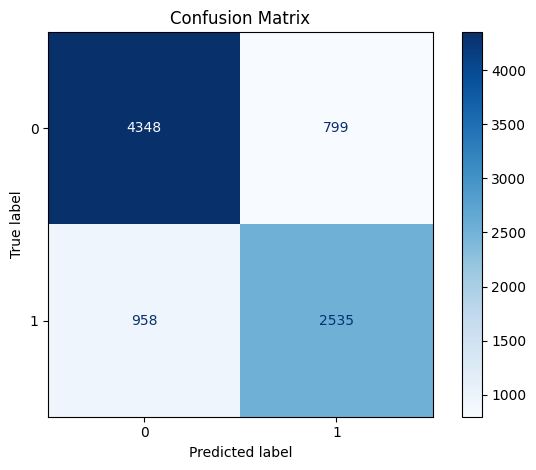

MAE: Flood XGBClassifier k_fold Mean MAE: 0.2013 ± 0.0036
Accuracy: Flood XGBClassifier k_fold Mean Accuracy: 0.7987 ± 0.0036

--- Processing Weather Event: Drought ---


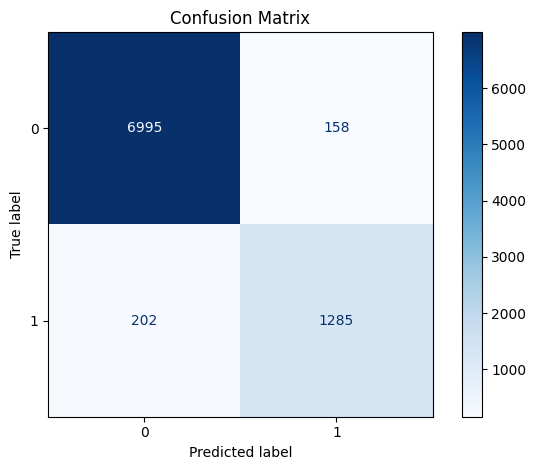

MAE: Drought XGBClassifier k_fold Mean MAE: 0.0428 ± 0.0016
Accuracy: Drought XGBClassifier k_fold Mean Accuracy: 0.9572 ± 0.0016

--- Processing Weather Event: Tornado ---


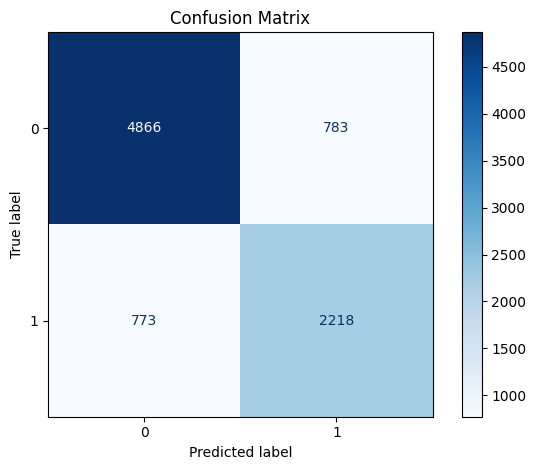

MAE: Tornado XGBClassifier k_fold Mean MAE: 0.1794 ± 0.0035
Accuracy: Tornado XGBClassifier k_fold Mean Accuracy: 0.8206 ± 0.0035

--- Processing Weather Event: Blizzard ---


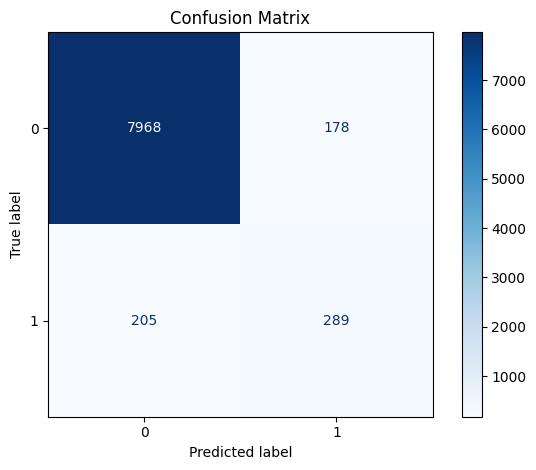

MAE: Blizzard XGBClassifier k_fold Mean MAE: 0.0455 ± 0.0018
Accuracy: Blizzard XGBClassifier k_fold Mean Accuracy: 0.9545 ± 0.0018

--- Processing Weather Event: Ice Storm ---


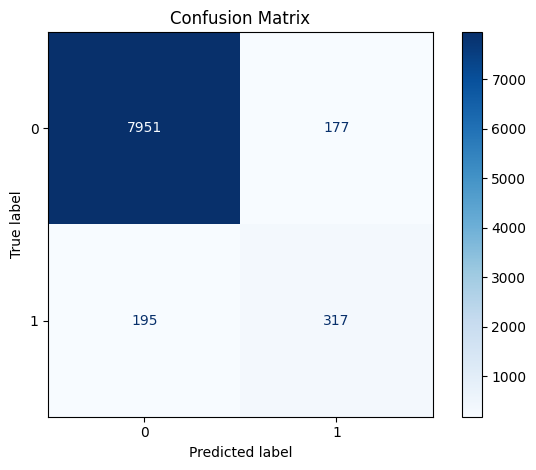

MAE: Ice_Storm XGBClassifier k_fold Mean MAE: 0.0450 ± 0.0025
Accuracy: Ice_Storm XGBClassifier k_fold Mean Accuracy: 0.9550 ± 0.0025

--- Processing Weather Event: Excessive Heat ---


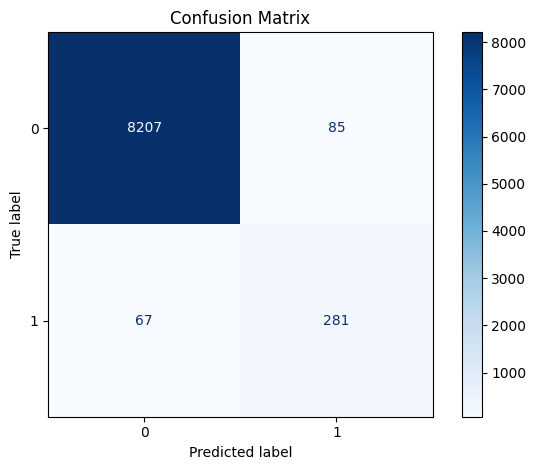

MAE: Excessive_Heat XGBClassifier k_fold Mean MAE: 0.0180 ± 0.0010
Accuracy: Excessive_Heat XGBClassifier k_fold Mean Accuracy: 0.9820 ± 0.0010

--- Processing Weather Event: Wildfire ---


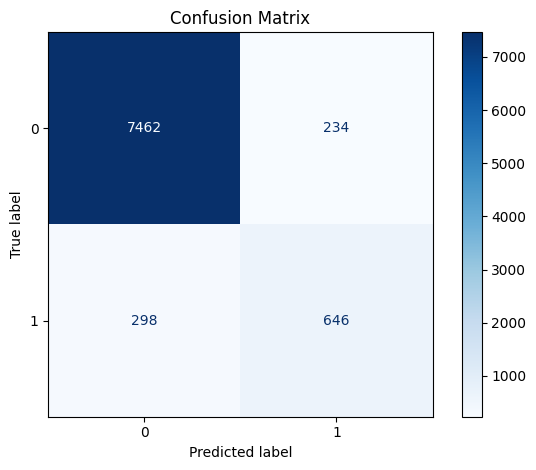

MAE: Wildfire XGBClassifier k_fold Mean MAE: 0.0622 ± 0.0018
Accuracy: Wildfire XGBClassifier k_fold Mean Accuracy: 0.9378 ± 0.0018

--- Processing Weather Event: Tropical Storm ---


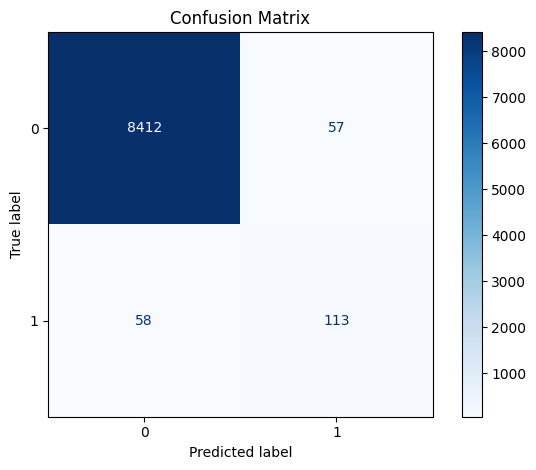

MAE: Tropical_Storm XGBClassifier k_fold Mean MAE: 0.0121 ± 0.0007
Accuracy: Tropical_Storm XGBClassifier k_fold Mean Accuracy: 0.9879 ± 0.0007

--- Processing Weather Event: Hurricane ---


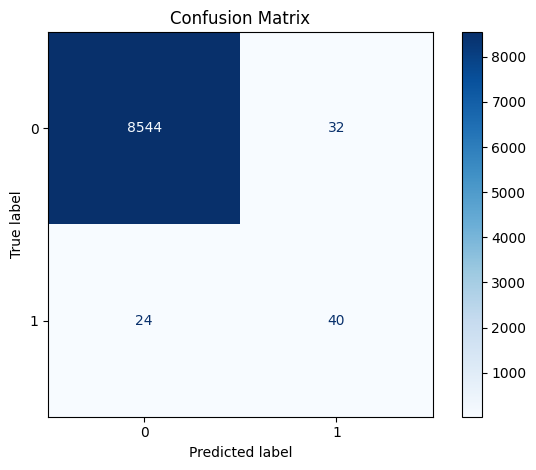

MAE: Hurricane XGBClassifier k_fold Mean MAE: 0.0052 ± 0.0006
Accuracy: Hurricane XGBClassifier k_fold Mean Accuracy: 0.9948 ± 0.0006

--- Processing Weather Event: Tropical Depression ---


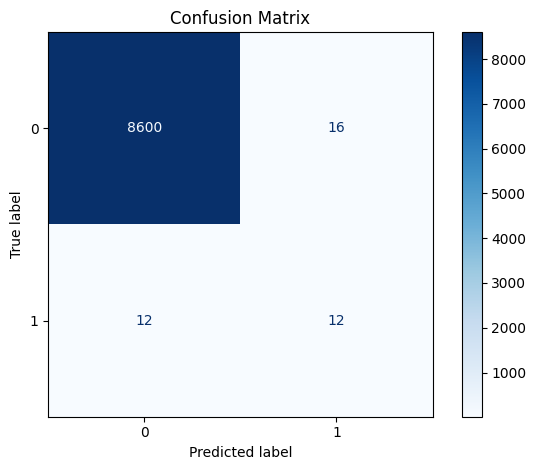

MAE: Tropical_Depression XGBClassifier k_fold Mean MAE: 0.0029 ± 0.0005
Accuracy: Tropical_Depression XGBClassifier k_fold Mean Accuracy: 0.9971 ± 0.0005

--- Processing Weather Event: Frost/Freeze ---


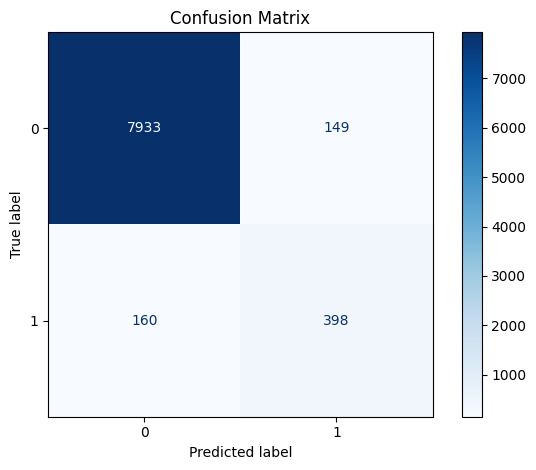

MAE: Frost_Freeze XGBClassifier k_fold Mean MAE: 0.0338 ± 0.0013
Accuracy: Frost_Freeze XGBClassifier k_fold Mean Accuracy: 0.9662 ± 0.0013

--- Processing Weather Event: Flash Flood ---


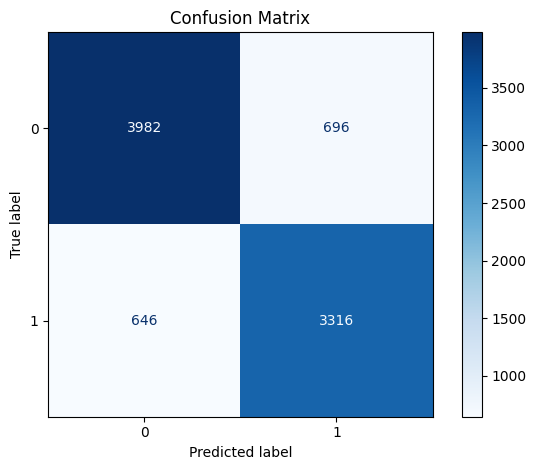

MAE: Flash_Flood XGBClassifier k_fold Mean MAE: 0.1602 ± 0.0041
Accuracy: Flash_Flood XGBClassifier k_fold Mean Accuracy: 0.8398 ± 0.0041

--- Predicting Weather Event: Flood ---
[0 0 1 ... 1 1 0]
       year month  global_land_temp  global_ocean_temp  co2_levels state_code  \
0      2030    01               1.5                0.5         400         AL   
1      2030    01               1.5                0.5         400         AZ   
2      2030    01               1.5                0.5         400         AR   
3      2030    01               1.5                0.5         400         CA   
4      2030    01               1.5                0.5         400         CO   
...     ...   ...               ...                ...         ...        ...   
52795  2030    01               4.2                2.3         500         VA   
52796  2030    01               4.2                2.3         500         WA   
52797  2030    01               4.2                2.3         500        

In [37]:
all_weather_events = [
    'Flood', 'Drought', 'Tornado', 'Blizzard', 'Ice Storm',
    'Excessive Heat', 'Wildfire', 'Tropical Storm',
    'Hurricane', 'Tropical Depression', 'Frost/Freeze', 'Flash Flood'
]

#keep_columns = ["year","month","global_land_temp", "global_ocean_temp", "co2_levels", "state_code", "region_name"]
keep_columns = ["month","global_land_temp", "global_ocean_temp", "co2_levels", "state_code", "region_name"]
#keep_columns = ["global_land_temp", "global_ocean_temp", "co2_levels", "state_code", "region_name"]
#keep_columns = ["global_land_temp", "global_ocean_temp", "co2_levels"]

# TRAINING 
results_by_events, X, y = run_all_weather_event_models("_input_table",all_weather_events,keep_columns)

# PREDICTING FUCTIONS
all_predicted_results = predict_all_weather_event_models("_input_predicting_table", results_by_events,keep_columns)


In [38]:
print("Accuracy and MAE for all models\nBased on the features",keep_columns)
print('-----------------------')
for event, result in results_by_events.items():
    print(f"{result['Accuracy']}")
print('-----------------------')
for event, result in results_by_events.items():
    print(f"{result['MAE']}")

Accuracy and MAE for all models
Based on the features ['month', 'global_land_temp', 'global_ocean_temp', 'co2_levels', 'state_code', 'region_name']
-----------------------
Flood XGBClassifier k_fold Mean Accuracy: 0.7987 ± 0.0036
Drought XGBClassifier k_fold Mean Accuracy: 0.9572 ± 0.0016
Tornado XGBClassifier k_fold Mean Accuracy: 0.8206 ± 0.0035
Blizzard XGBClassifier k_fold Mean Accuracy: 0.9545 ± 0.0018
Ice_Storm XGBClassifier k_fold Mean Accuracy: 0.9550 ± 0.0025
Excessive_Heat XGBClassifier k_fold Mean Accuracy: 0.9820 ± 0.0010
Wildfire XGBClassifier k_fold Mean Accuracy: 0.9378 ± 0.0018
Tropical_Storm XGBClassifier k_fold Mean Accuracy: 0.9879 ± 0.0007
Hurricane XGBClassifier k_fold Mean Accuracy: 0.9948 ± 0.0006
Tropical_Depression XGBClassifier k_fold Mean Accuracy: 0.9971 ± 0.0005
Frost_Freeze XGBClassifier k_fold Mean Accuracy: 0.9662 ± 0.0013
Flash_Flood XGBClassifier k_fold Mean Accuracy: 0.8398 ± 0.0041
-----------------------
Flood XGBClassifier k_fold Mean MAE: 0.2013 ±

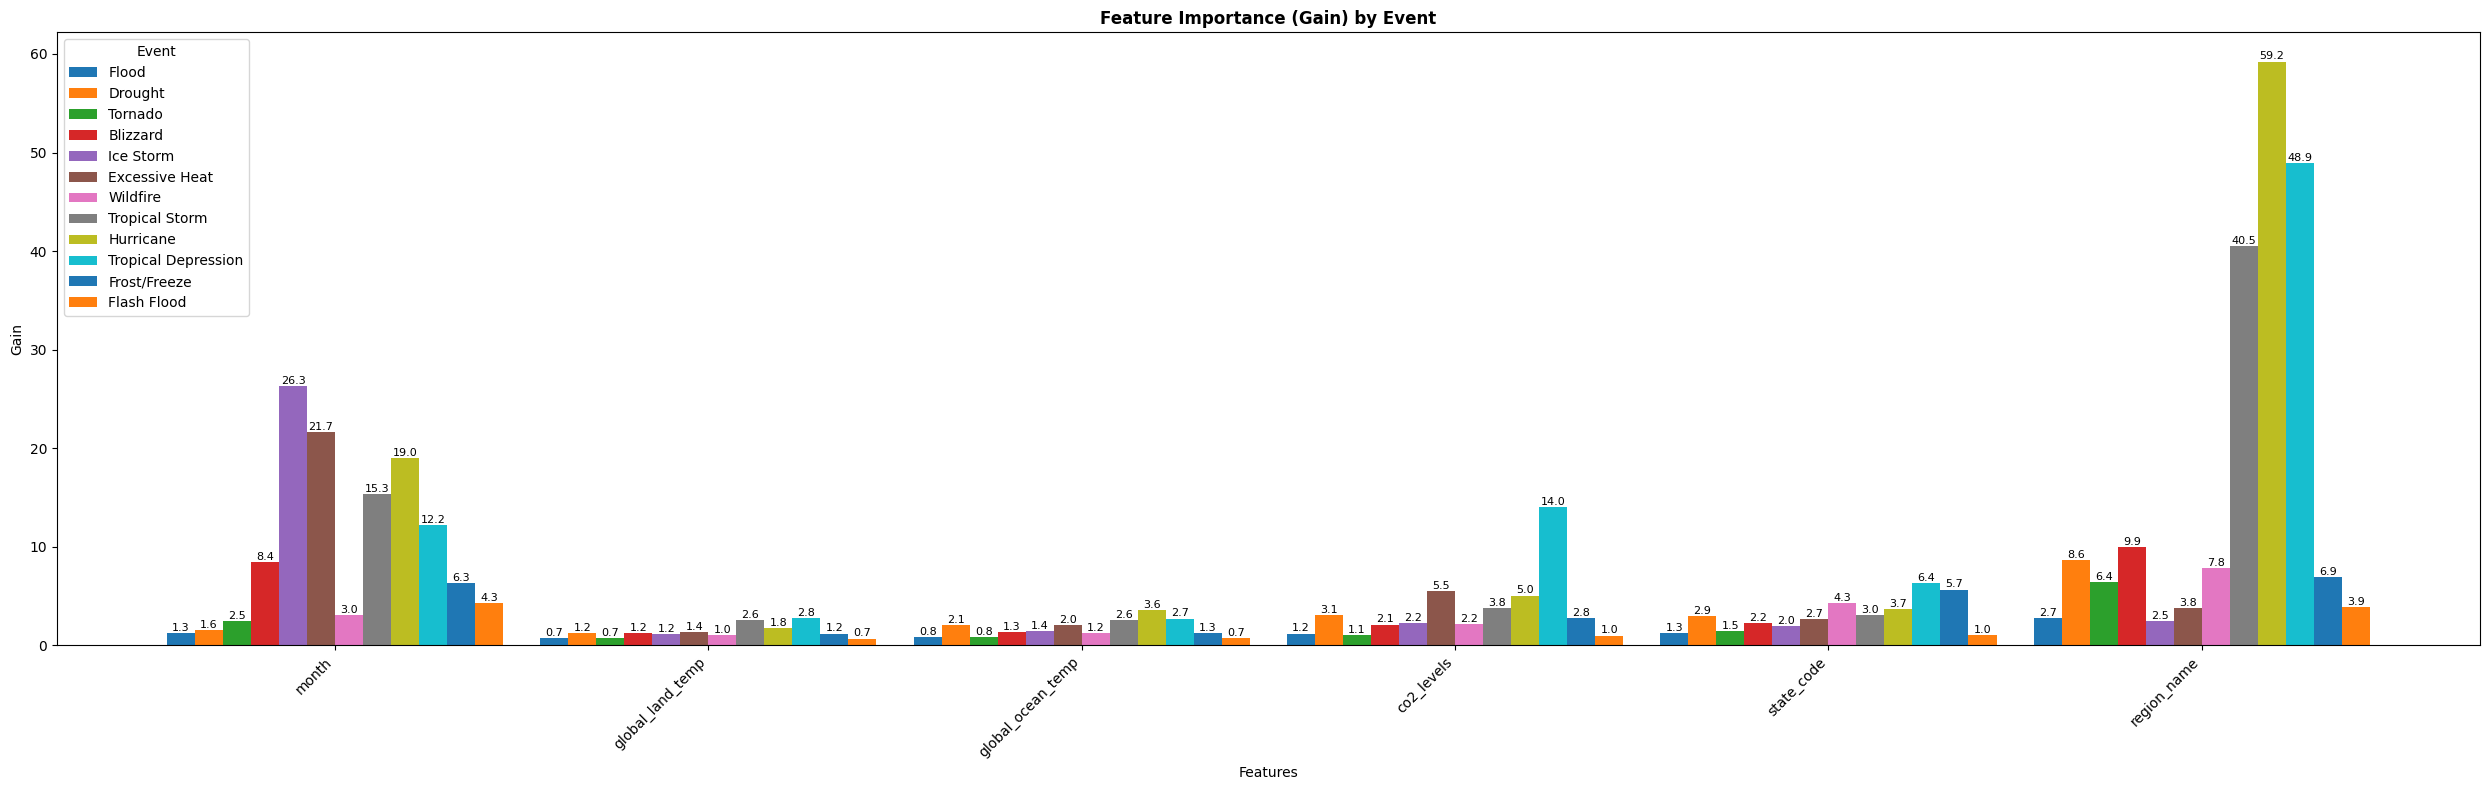

In [39]:
# RETURN FEATURE IMPORTANCE OF A MODEL AND PLOT TOGETHER 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect importance data into a DataFrame
importance_df = pd.DataFrame()

for event, result in results_by_events.items():
    model = result["Model"]
    booster = model.get_booster()
    importance = booster.get_score(importance_type='gain')
    feature_map = {f"f{i}": col for i, col in enumerate(X.columns)}
    importance_named = {feature_map[k]: v for k, v in importance.items()}
    
    # Create DataFrame for this event
    event_df = pd.Series(importance_named, name=event)
    importance_df = pd.concat([importance_df, event_df], axis=1)

# Fill NaNs with 0
importance_df = importance_df.fillna(0)

# Plot
features = importance_df.index.tolist()
events = importance_df.columns.tolist()
x = np.arange(len(features))  # X-axis positions for features
width = 0.9 / len(events)     # Bar width

plt.figure(figsize=(25, 8))

# Plot a bar for each event
for i, event in enumerate(events):
    gains = importance_df[event]
    bars = plt.bar(x + i * width, gains, width=width, label=event)
    
    # Add gain values above each bar
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
                     f"{height:.1f}", ha='center', va='bottom', fontsize=8)

# Labels and layout
plt.xlabel("Features")
plt.ylabel("Gain")
plt.title("Feature Importance (Gain) by Event", fontweight='bold')
plt.xticks(x + width * (len(events) - 1) / 2, features, rotation=45, ha='right')
plt.legend(title="Event")
plt.tight_layout()
plt.show()


In [128]:
# SCRIPT THAT UNIONS ALL PREDICTED RESULTS, adds a column for the event, AND SAVES IT TO SQL 

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine, text
import os

# Configuration
DB_CONFIG = {
    "username": "agowen",  # Replace with your PostgreSQL username
    "password": "Capstone",  # Replace with your PostgreSQL password
    "host": "localhost",  # Replace with your PostgreSQL host
    "port": 5432,  # Replace with your PostgreSQL port (default: 5432)
    "database": "capstone_db_testing",  # Replace with your PostgreSQL database name
}

# Connection string for PostgreSQL
CONN_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@" \
              f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Database setup
engine = create_engine(CONN_STRING)

def union_tables_with_label(tables_dict):
    df_list = []

    for event in tables_dict:
        table = tables_dict[event]["predictions"]

        df_copy = table.copy()
        df_copy['event_name'] = event  # Add new column with dictionary key as the source label
        df_list.append(df_copy)

    return pd.concat(df_list, ignore_index=True)

def save_dataframe_to_excel(df, output_path):
    """
    Saves a pandas DataFrame to an Excel file with headers at the specified path.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    output_path (str): Full path (including filename) for the output Excel file.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the DataFrame as an Excel file
    df.to_excel(output_path, index=False, header=True)
    print(f"DataFrame saved to '{output_path}'")

def create_predictions_table(predcition_dict):
    """
    Creates a new table in the database with the predicted values for each column.
    """
    table_name = f"prediction_result"
    # Write the result dataframe to a new table in the database

    unioned_tables = union_tables_with_label(predcition_dict)

    try:
        with engine.connect() as connection:
            unioned_tables.to_sql(table_name, connection, if_exists='replace', index=False)
            print(f"Table '{table_name}' created successfully.")
    except Exception as e:
        print(f"Error creating table: {e}")

    # Save to Excel file
    save_dataframe_to_excel(unioned_tables, 'C:/Users/Alex/Desktop/Home_Documents/_Tufts/DS-288/Data/prediction_result.xlsx')

def main():

    create_predictions_table(all_predicted_results)

if __name__ == "__main__":
    main()


Table 'prediction_result' created successfully.
DataFrame saved to 'C:/Users/Alex/Desktop/Home_Documents/_Tufts/DS-288/Data/prediction_result.xlsx'
